# Exercise 5.3 - Transmission / Reflection

I copied the notebook I used for 5.1 and 5.2 to start making this one, so some parts may be left over from there.

In [1]:
## IMPORTS
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy.signal.windows import triang, hamming
from copy import deepcopy

from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2D
from kwave.utils.signals import tone_burst
from kwave.kWaveSimulation import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.colormap import get_color_map

In [2]:
## SET UP SIMULATION

c0 = 1540                       # [m/s] Speed of sound
rho0 = 1000                     # [kg/m^3] Density of water
source_f0 = 1e6                 # [Hz] Source frequency
source_amp = 1e6                # [Pa] Source amplitude
source_cycles = 2               # Number of cycles in the pulse
source_aperture = 2e-2          # Aperture size

grid_size_x = 80e-3             # [m] Grid size in x (NB: Depth in k-Wave)
grid_size_y = 40e-3             # [m] Grid size in z (NB: Width in k-Wave)
ppw = 5                       # Points per wavelength
cfl = 0.05                       # Related to the time resolution, lower is more accurate (no need to change)

# Setup Grid
dx = c0 / (ppw * source_f0)     # Grid resolution
Nx = round(grid_size_x / dx)    # Number of grid points in x, NB: This is depth
Ny = round(grid_size_y / dx)    # Number of grid points in y, NB: This is width (lateral)

# Make sure Ny is odd to make centering easier
if Ny % 2 == 0:
    Ny += 1

kgrid = kWaveGrid([Nx, Ny], [dx, dx])
kgrid.makeTime(c0, cfl, t_end=2*grid_size_x/c0)         # Make time array based on the Courant-Friedrichs-Lewy (CFL) condition

# Setup source
source_pos = [-grid_size_y, 0]
N_source_x = np.max(np.round((source_pos[0] - kgrid.x_vec[0]) / dx).astype(int)[0], 0)
z_ax = kgrid.x_vec - kgrid.x_vec[0]
extent = np.array([z_ax[0], z_ax[-1], kgrid.y_vec[0], kgrid.y_vec[-1]])*1e3

# Define kWave source object
source = kSource()
source.p_mask = np.zeros_like(kgrid.x)

N_aperture = round(source_aperture/dx)
if N_aperture % 2 == 0:
    N_aperture += 1

N_source_y = np.round((np.arange(kgrid.Ny/2 - N_aperture/2, kgrid.Ny/2 + N_aperture/2, 1))).astype(int)

source.p_mask[N_source_x, N_source_y] = 1
print(source.p_mask.shape)

# Setup sensor
sensor = kSensor(record=['p', 'p_max'])                     # Sensor object, record pressure and maximum pressure
sensor.mask = np.ones_like(kgrid.x)                         # Sensor mask, all grid points

# Setup medium
medium = kWaveMedium(sound_speed=c0, density=rho0)          # Define medium object, simple homogeneous medium
medium.sound_speed = np.ones_like(kgrid.x) * c0
medium.density = np.ones_like(kgrid.x) * rho0
# Add scatterers to medium
scattererPositions = [10e-3, 30e-3, 50e-3, 70e-3]
medium.density[[np.argmin(np.abs(kgrid.x_vec - kgrid.x_vec[0] - pos)) for pos in scattererPositions], int(Ny/2)] = 4000

(260, 131)


65
dt: 1.00e-08. Fs: 1.00e+08


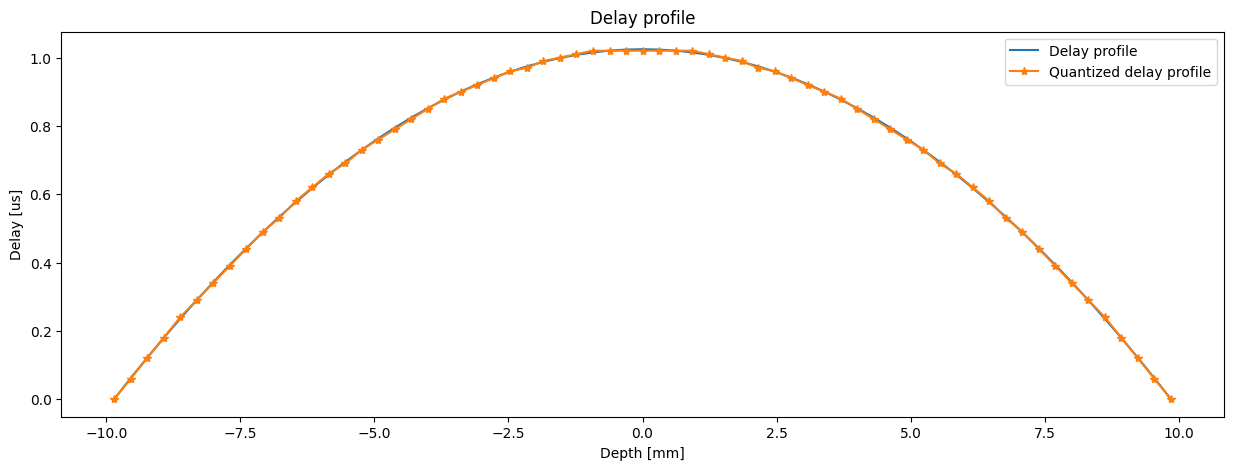

In [3]:
def delay_profile(source, fp, angle):
    x = source[0]
    y = source[1]

    dx = x - fp[0]
    dy = y - fp[1]
    d_source_fp = np.sqrt(dx**2 + dy**2)

    center_x = x[len(x)//2] - fp[0]
    center_y = y[len(y)//2] - fp[1]
    d_center = np.sqrt(center_x**2 + center_y**2)

    delay_profile = (d_center - d_source_fp) / c0
    delay_profile = delay_profile - np.min(delay_profile)

    # delay_profile += np.tan(angle) * y / c0
    delay_profile = delay_profile + np.tan(angle) * y / c0

    return delay_profile

focal_point = np.array([0.03, 0])
angle = 0
# angle = 5
source_x_y = [np.zeros_like(kgrid.y_vec[N_source_y]), kgrid.y_vec[N_source_y]]

dp = delay_profile(source_x_y, focal_point, angle*np.pi/180)

quantized = np.round(dp / kgrid.dt).astype(int)
quantized -= np.min(quantized)

print(len(quantized))
# print(dp)

print(f"dt: {kgrid.dt:.2e}. Fs: {1/kgrid.dt:.2e}")

plt.figure(figsize=(15, 5))
plt.plot(source_x_y[1]*1e3, dp*1e6)
plt.plot(source_x_y[1]*1e3, quantized*kgrid.dt*1e6, "*-")
plt.title("Delay profile")
plt.xlabel("Depth [mm]")
plt.ylabel("Delay [us]")
plt.legend(["Delay profile", "Quantized delay profile"])

In [4]:
# source_amp = source_amp * np.expand_dims(triang(len(quantized)), 1) # Apodization: triangular window
# source_amp = source_amp * np.expand_dims(hamming(len(quantized)), 1) # Apodization: hamming window
source.p = source_amp * tone_burst(1 / kgrid.dt, source_f0, source_cycles, signal_offset=quantized)
print(source.p.shape)

# Setup simulation options
simulation_options = SimulationOptions(
    pml_auto=True,
    pml_inside=False,
    save_to_disk=True,
    data_cast='single',
)
execution_options = SimulationExecutionOptions(is_gpu_simulation=False)

# Run 2D simulation (to save some time)
sensor_data = kspaceFirstOrder2D(kgrid=kgrid, medium=medium, source=source, sensor=sensor,
                                  simulation_options=simulation_options, execution_options=execution_options)

# Extract pressure field from
p_field = np.reshape(sensor_data["p"], (kgrid.Nt, Nx, Ny), order="F")   # Stored in Fortran ordering for some reason

(65, 302)
┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                     16 │
│ Processor name: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                                  288 x 175 │
│ Medium type:                                               2D │
│ Simulation time steps:                                  10390 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤


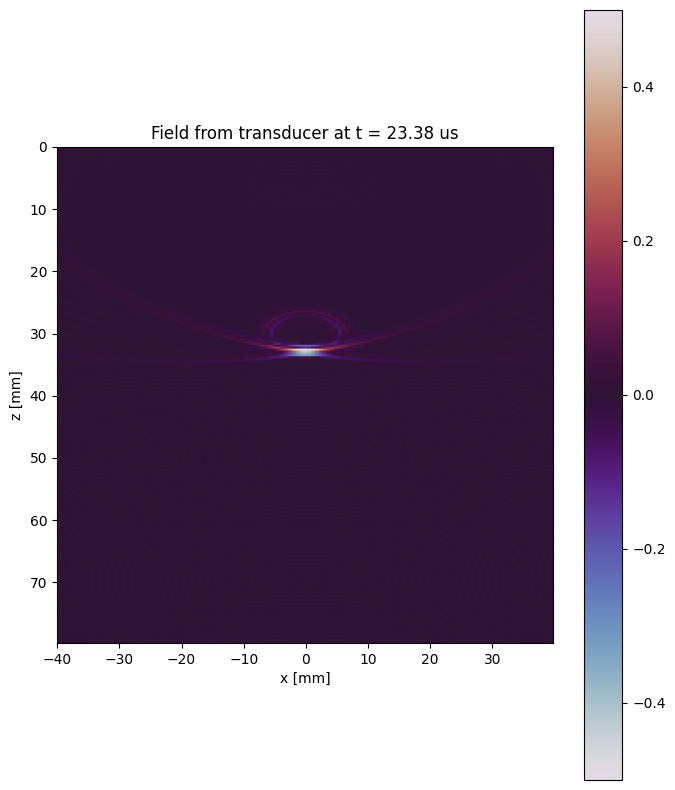

In [25]:
# P-field visualization

vt = grid_size_x / 2 / c0 * 0.9 # Time to vizualize [s]
NFrames = np.round(np.where(kgrid.t_array[0] > vt)[0][0]).astype(int) # Number of frames to vizualize

pPlot = p_field / np.max(np.abs(p_field)) # Normalize frames

z_ax = kgrid.x_vec - kgrid.x_vec[0]

extent = np.array([kgrid.x_vec[0], kgrid.x_vec[-1], z_ax[-1], z_ax[0]])*1e3

fig, ax = plt.subplots(figsize=(8, 10))
img = plt.imshow(pPlot[NFrames], cmap="twilight", vmin=-0.5, vmax=0.5, extent=extent)
plt.colorbar()
plt.xlabel("x [mm]")
plt.ylabel("z [mm]")
plt.title(f"Field from transducer at t = {vt*1e6:.2f} us")
plt.show()


In [26]:

# Create animation showing propagation over time
def update(frame):
    img.set_data(pPlot[frame])
    ax.set_title(f"Frame: {frame}/{kgrid.Nt}")
    return [img]

ANIM_START = 0
ANIM_END = int(kgrid.Nt * 0.6)
ANIM_STEP = 15
ANIM_FILENAME = "task3_beam.mp4"

animation = FuncAnimation(fig, update, frames=np.arange(ANIM_START, ANIM_END, ANIM_STEP), interval=100, blit=True)

from os import makedirs
makedirs(f"../output/5/", exist_ok=True)
animation.save(f"../output/5/{ANIM_FILENAME}", writer='ffmpeg', fps=25)

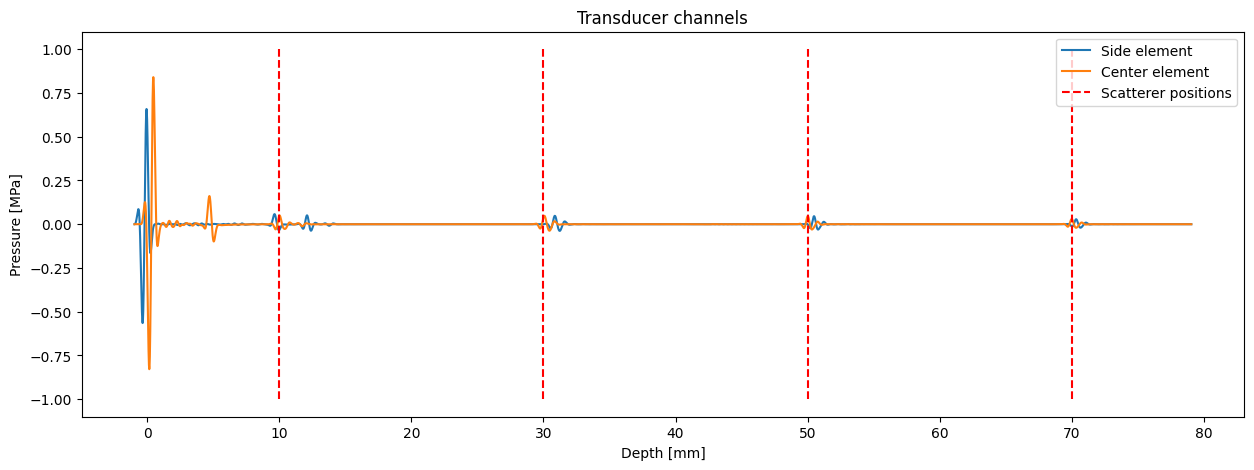

In [18]:
# Pressure over time from transducer element sensor points (channel data)

sensorElements = p_field[:, N_source_x, N_source_y]

sideElementTrace = np.expand_dims(sensorElements[:,0], 1)
centerElementTrace = np.expand_dims(sensorElements[:,int(len(N_source_y)/2)], 1)

ztAxis = kgrid.t_array.T * c0 / 2
ztAxis -= np.max(quantized) * kgrid.dt * c0

plt.figure(figsize=(15, 5))
plt.plot(ztAxis*1e3, sideElementTrace*1e-6)
plt.plot(ztAxis*1e3, centerElementTrace*1e-6)
plt.title("Transducer channels")
plt.xlabel("Depth [mm]")
plt.ylabel("Pressure [MPa]")
[plt.plot([z*1e3, z*1e3], [-1, 1], "r--") for z in scattererPositions]
plt.legend(["Side element", "Center element", "Scatterer positions"], loc="upper right")

plt.show()

## Observations (5.3)

b)

In the plot we see the transmit pulse first, then around the expected depths we see the response from the scatterers.

We can also see the transmit pulse is delayed on the center element compared to the side element, which makes sense given that we have applied a signal offset to delay elements more as they get closer to the center.

It seems strange then that in the received pulses coming back we see the side elements show the scatterers at a slightly greater depth (which implies the pulse took longer to get there and back). This is caused by the fact that our depth-axis is defined relative to the center, so on that axis the side element is further away and we actually expect to see the responses from the side elements appear deeper in the plot.

c)

With the focus set close (1cm), we see the response from the nearest scatterer (also 1cm) very clearyly while the other ones are barely visible. With the focus set further away (5cm), the response from all the scatterers have a more uniform response (almost the same for all of them, but getting a bit weaker the deeper in you go).


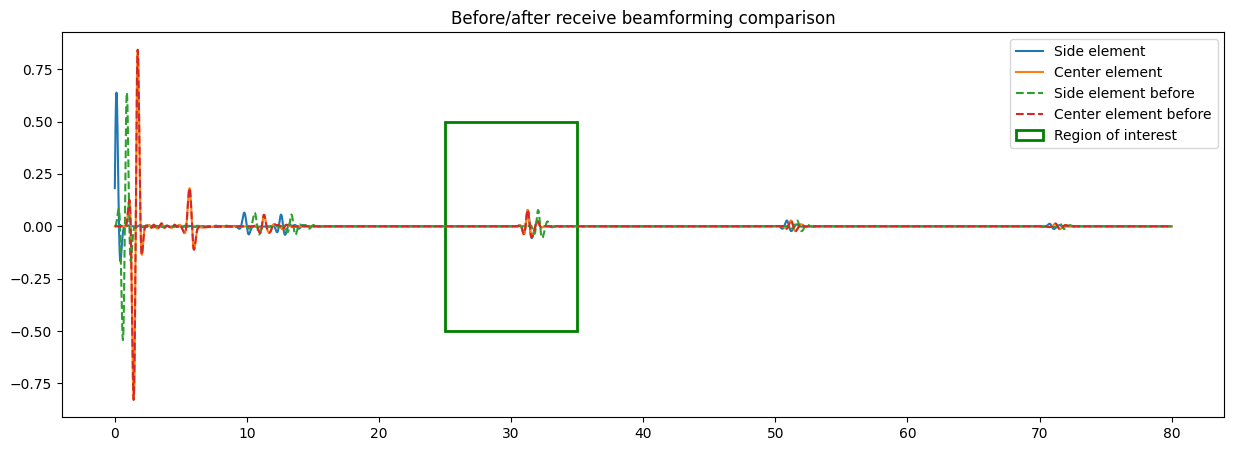

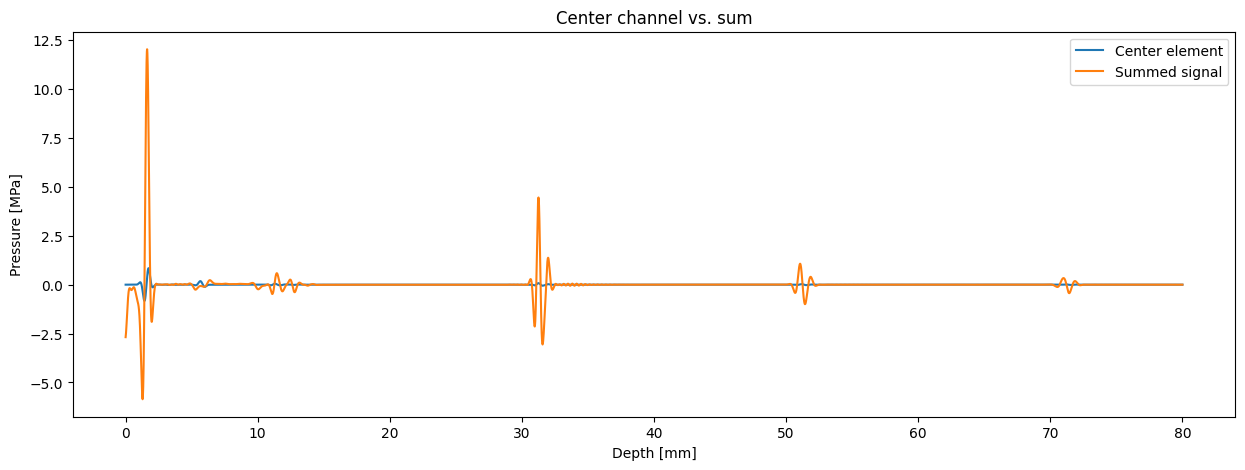

In [ ]:
# Receive beamforming
sensorElements = p_field[:, N_source_x, N_source_y]
sensorElementsBefore = deepcopy(sensorElements)

# focal_point = np.array([0.01, 0])

dpReceive = delay_profile(source_x_y, focal_point, angle*np.pi/180)
quantizedReceive = np.round(dpReceive / kgrid.dt).astype(int)

receiveDelays = np.max(quantizedReceive) - quantizedReceive
for i in range(len(N_source_y)):
    d = receiveDelays[i][0]
    sensorElements[:,i] = np.roll(sensorElements[:,i], -d)
    sensorElements[-d::,i] = 0 # Set wrapped values to zero

signalSum = np.sum(sensorElements, axis=1)

sideElementTrace = np.expand_dims(sensorElements[:,0], 1)
centerElementTrace = np.expand_dims(sensorElements[:,int(len(N_source_y)/2)], 1)
sumTrace = np.expand_dims(signalSum, 1)

sideElementTraceBefore = np.expand_dims(sensorElementsBefore[:,0], 1)
centerElementTrace = np.expand_dims(sensorElementsBefore[:,int(len(N_source_y)/2)], 1)

ztAxis = kgrid.t_array.T * c0 / 2
# ztAxis -= np.max(quantized) * kgrid.dt * c0

plt.figure(figsize=(15, 5))
plt.title("Before/after receive beamforming comparison")
plt.plot(ztAxis*1e3, sideElementTrace*1e-6)
plt.plot(ztAxis*1e3, centerElementTrace*1e-6)
plt.plot(ztAxis*1e3, sideElementTraceBefore*1e-6, "--")
plt.plot(ztAxis*1e3, centerElementTrace*1e-6, "--")
plt.gca().add_patch(Rectangle((focal_point[0]*1e3-5, -0.5), 10, 1, fill=False, edgecolor="green", lw=2))
plt.legend(["Side element", "Center element", "Side element before", "Center element before", "Region of interest"], loc="upper right")

plt.figure(figsize=(15, 5))
plt.title("Center channel vs. sum")
# plt.plot(ztAxis*1e3, sideElementTrace*1e-6)
plt.plot(ztAxis*1e3, centerElementTrace*1e-6)
plt.plot(ztAxis*1e3, sumTrace*1e-6)
plt.xlabel("Depth [mm]")
plt.ylabel("Pressure [MPa]")
# [plt.plot([z*1e3, z*1e3], [-1, 1], "r--", lw=1) for z in scattererPositions]
# # plt.plot([focal_point[0]*1e3, focal_point[0]*1e3], [-1, 1], "g--")
plt.legend(["Center element", "Summed signal"], loc="upper right")

plt.show()

## Observations (5.4)

a)

We see that after receive beamforming, the signals from the side- and center-elements are aligned inside the region of interest.

b)

The summed signal has a greater amplitude overall, but it's especially high in the region of interest (around the focal point). This is because the phase corrections from the receive beamforming (the signals line up) means we have more constructive interference here (cohesive summation).

c)

With both the transmit- and receive focus set to 2cm we see that the center- and side elements no longer align perfectly and the summed signal ends up having a smaller amplitude. Looking closer at the signal from the scatterer at 3cm, it looks like the center- and side elements are very close to being one half cycle out of phase (which would cause mostly destructive interference), but since there are more "side-ish" elements than "center-ish" elements we still end up with a greater amplitude in the summed signal compared to just the center element on its own.

d)


